In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tqdm.pandas()

device = torch.device('cuda')

In [ ]:
bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
data = pd.read_csv('parsed_articles.csv', usecols=['Post', 'hubs']).astype({"Post": str})

In [ ]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")

reg_tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data['Post_clean'] = data['Post'].\
  map(lambda text: [token for token in reg_tokenizer.tokenize(text.lower()) if token not in russian_stopwords and token not in string.punctuation]).\
  map(lambda words: " ".join(words))

In [ ]:
from ast import literal_eval

data['hubs'] = data['hubs'].map(lambda x: literal_eval(x)[0])
data.head()

,Post,hubs,Post_clean
0,Привет! Для сборника ответов на Часто Задаваем...,Habr,привет сборника ответов часто задаваемые вопро...
1,"Кроме неработающих и отсутствующих страниц, о ...",Habr,кроме неработающих отсутствующих страниц котор...
2,"Насколько я знаю, Google выбрал агентство «Мас...",Чулан,насколько знаю google выбрал агентство маслов ...
3,Мы планируем добавить в раздел «тексты» возмож...,Habr,планируем добавить раздел тексты возможность п...
4,"У меня такое ощущение, что logout время от вре...",Habr,такое ощущение logout время времени происходит...


In [ ]:
data = data[data['Post_clean'].map(len) < 1000]

In [ ]:
p = pd.DataFrame(data['hubs'].value_counts())
p = p.loc[p['hubs'] > 100]
p

,hubs
Чулан,1216
Habr,270
IT-компании,186


In [ ]:
data_clean = data.loc[data['hubs'].isin(p.index)]

labels_dict = {cat: idx for idx, cat in enumerate(p.index)}
data_clean['hubs_encoded'] = data_clean['hubs'].map(labels_dict)

<ipython-input-9-b161e0d8eae7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['hubs_encoded'] = data_clean['hubs'].map(labels_dict)


In [ ]:
labels_dict

{'Чулан': 0, 'Habr': 1, 'IT-компании': 2}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_clean['Post'], data_clean['hubs_encoded'], test_size=0.4, random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
len(X_train), len(X_val), len(X_test)

(1003, 334, 335)

In [ ]:
train_text = X_train
train_labels = y_train
val_text = X_val
val_labels = y_val
test_text = X_test
test_labels = y_test

<Axes: >

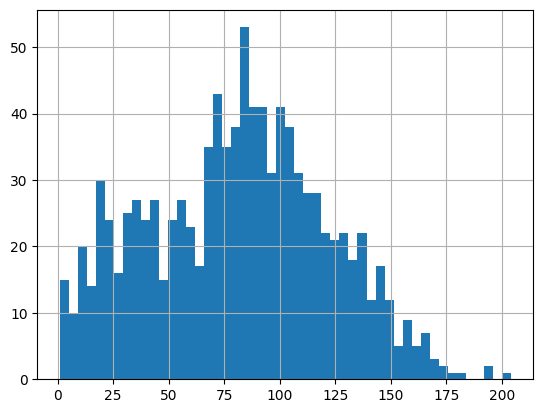

In [ ]:
seq_len = [len(str(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins = 50)

In [ ]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.values,
    max_length = 130,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.values,
    max_length = 130,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.values,
    max_length = 130,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)
batch_size = 8


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,3)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
model = BERT_Arch(bert)

model = model.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr= 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = 'balanced', classes=np.unique(train_labels), y=train_labels)

print(class_weights)

weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss()
epochs = 20

[0.4530262  2.01405622 3.37710438]


In [ ]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [ ]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [ ]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 20


100%|██████████| 42/42 [00:02<00:00, 16.59it/s]



Training loss: 0.617
Validation loss: 0.694

 Epoch2 / 20


100%|██████████| 42/42 [00:02<00:00, 16.41it/s]



Training loss: 0.517
Validation loss: 0.630

 Epoch3 / 20


100%|██████████| 42/42 [00:02<00:00, 15.85it/s]



Training loss: 0.475
Validation loss: 0.645

 Epoch4 / 20


100%|██████████| 42/42 [00:02<00:00, 15.61it/s]



Training loss: 0.474
Validation loss: 0.570

 Epoch5 / 20


100%|██████████| 42/42 [00:02<00:00, 15.49it/s]



Training loss: 0.449
Validation loss: 0.583

 Epoch6 / 20


100%|██████████| 42/42 [00:02<00:00, 14.94it/s]



Training loss: 0.431
Validation loss: 0.851

 Epoch7 / 20


100%|██████████| 42/42 [00:02<00:00, 14.41it/s]



Training loss: 0.425
Validation loss: 0.660

 Epoch8 / 20


100%|██████████| 42/42 [00:03<00:00, 13.76it/s]



Training loss: 0.454
Validation loss: 0.635

 Epoch9 / 20


100%|██████████| 42/42 [00:03<00:00, 13.75it/s]



Training loss: 0.406
Validation loss: 0.646

 Epoch10 / 20


100%|██████████| 42/42 [00:02<00:00, 14.26it/s]



Training loss: 0.408
Validation loss: 0.526

 Epoch11 / 20


100%|██████████| 42/42 [00:02<00:00, 14.73it/s]



Training loss: 0.404
Validation loss: 0.673

 Epoch12 / 20


100%|██████████| 42/42 [00:02<00:00, 14.09it/s]



Training loss: 0.428
Validation loss: 0.676

 Epoch13 / 20


100%|██████████| 42/42 [00:03<00:00, 13.88it/s]



Training loss: 0.427
Validation loss: 0.662

 Epoch14 / 20


100%|██████████| 42/42 [00:02<00:00, 14.18it/s]



Training loss: 0.392
Validation loss: 0.559

 Epoch15 / 20


100%|██████████| 42/42 [00:02<00:00, 14.29it/s]



Training loss: 0.370
Validation loss: 0.696

 Epoch16 / 20


100%|██████████| 42/42 [00:02<00:00, 14.40it/s]



Training loss: 0.398
Validation loss: 0.766

 Epoch17 / 20


100%|██████████| 42/42 [00:02<00:00, 14.46it/s]



Training loss: 0.366
Validation loss: 0.530

 Epoch18 / 20


100%|██████████| 42/42 [00:02<00:00, 14.31it/s]



Training loss: 0.358
Validation loss: 0.636

 Epoch19 / 20


100%|██████████| 42/42 [00:02<00:00, 14.19it/s]



Training loss: 0.365
Validation loss: 0.612

 Epoch20 / 20


100%|██████████| 42/42 [00:02<00:00, 14.23it/s]


Training loss: 0.364
Validation loss: 0.560


In [ ]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

list_seq = np.array_split(test_seq, 50)
list_mask = np.array_split(test_mask, 50)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())

In [ ]:
print(classification_report(y_test, [item.argmax() for sublist in predictions for item in sublist]))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89       238
           1       0.83      0.71      0.76        55
           2       0.60      0.14      0.23        42

    accuracy                           0.82       335
   macro avg       0.75      0.60      0.63       335
weighted avg       0.80      0.82      0.79       335



In [28]:
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight

# Размораживаем BERT
for param in bert.parameters():
    param.requires_grad = True

# Изменяем гиперпараметры
batch_size = 16
learning_rate = 2e-5
epochs = 10

# Добавляем слои Dropout
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout1 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 512)
        self.dropout2 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(512, 3)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.dropout1(cls_hs)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [30]:
# Применяем веса классов для балансировки
class_weights = torch.tensor(compute_class_weight(class_weight = 'balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float)
class_weights = class_weights.to(device)

# Создаем оптимизатор и функцию потерь с весами классов
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [31]:
# Обучаем модель
for epoch in range(epochs):
    print('\nEpoch {:} / {:}'.format(epoch + 1, epochs))

    model.train()
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        optimizer.zero_grad()
        preds = model(sent_id, mask)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

    # Валидация
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, total=len(val_dataloader)):
            batch = [t.to(device) for t in batch]
            sent_id, mask, labels = batch
            preds = model(sent_id, mask)
            loss = criterion(preds, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Validation Loss: {avg_val_loss:.4f}')


Epoch 1 / 10


100%|██████████| 42/42 [00:02<00:00, 14.42it/s]


Validation Loss: 0.6917

Epoch 2 / 10


100%|██████████| 42/42 [00:03<00:00, 13.61it/s]


Validation Loss: 0.5523

Epoch 3 / 10


100%|██████████| 42/42 [00:03<00:00, 13.98it/s]


Validation Loss: 0.5976

Epoch 4 / 10


100%|██████████| 42/42 [00:03<00:00, 13.88it/s]


Validation Loss: 0.7897

Epoch 5 / 10


100%|██████████| 42/42 [00:03<00:00, 13.69it/s]


Validation Loss: 1.4874

Epoch 6 / 10


100%|██████████| 42/42 [00:03<00:00, 13.74it/s]


Validation Loss: 1.0785

Epoch 7 / 10


100%|██████████| 42/42 [00:03<00:00, 13.73it/s]


Validation Loss: 1.0624

Epoch 8 / 10


100%|██████████| 42/42 [00:03<00:00, 13.81it/s]


Validation Loss: 1.5965

Epoch 9 / 10


100%|██████████| 42/42 [00:03<00:00, 13.92it/s]


Validation Loss: 1.4100

Epoch 10 / 10


100%|██████████| 42/42 [00:03<00:00, 13.81it/s]

Validation Loss: 1.5856


In [33]:
import gc
gc.collect()
torch.cuda.empty_cache()

list_seq = np.array_split(test_seq, 50)
list_mask = np.array_split(test_mask, 50)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())

In [34]:
print(classification_report(y_test, [item.argmax() for sublist in predictions for item in sublist]))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       238
           1       0.81      0.85      0.83        55
           2       0.67      0.52      0.59        42

    accuracy                           0.86       335
   macro avg       0.79      0.76      0.77       335
weighted avg       0.85      0.86      0.85       335

